##  Imports

In [3520]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import warnings
import eurostat
import os

%matplotlib inline

In [3521]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [3522]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from sklearn.datasets import make_hastie_10_2
from xgboost import XGBRegressor

In [3523]:
sns.set_theme('notebook')
warnings.filterwarnings("ignore")

In [3524]:
PATH = "clean_data/sweden_eurostat.csv"
RANDOM_STATE = 11

## Utils

In [3525]:
def plot_dataframe(df: pd.DataFrame, n_cols: int = 4, plot: str = 'hist') -> None:
    """Plots numerical columns of a DataFrame as histograms or boxplots.

    Args:
        df (pd.DataFrame): Pandas DataFrame to plot.
        n_cols (int, optional): Number of columns for the plot layout. Defaults to 4.
        plot (str, optional): Type of plot to create ('hist' for histogram, 'box' for boxplot). Defaults to 'hist'.

    Returns:
        None
    """    
    num_cols = df.select_dtypes(include='number').columns
    n_rows = int(len(num_cols) / n_cols) + 1

    plots = ['hist', 'box']
    
    if plot not in plots:
        return print("Unknown plot option.")
    
    plt.figure(figsize=(20, 15))
    
    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        
        if plot == 'hist':
            sns.histplot(data=df, x=col, kde=True)
        elif plot == 'box':
            sns.boxplot(data=df, x=col)
        
        plt.title(col, fontsize=10)
        plt.tight_layout()

    plt.show()
    
    return None

In [3526]:
def impute_missing_data(raw_df: pd.DataFrame) -> pd.DataFrame:
    """Imputes missing data in a DataFrame.

    Args:
        raw_df (pd.DataFrame): Input DataFrame with missing values.

    Returns:
        pd.DataFrame: DataFrame with missing values imputed.
    """    
    df = raw_df.copy()
    df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], errors='coerce')
    df = df.set_index('TIME_PERIOD')
    
    numeric_cols = df.select_dtypes(include='number').columns
    
    for col in numeric_cols:
        df[col] = df[col].interpolate(method='time', limit_direction='both').round(1)
    
    return df

In [3527]:
def make_mi_scores(X: pd.DataFrame, y: pd.Series, discrete_features: list) -> pd.Series:
    """Calculate mutual information scores for features in X with respect to target y.

    Args:
        X (pd.DataFrame): Feature DataFrame.
        y (pd.Series): Target variable.
        discrete_features (list): List of discrete feature names.

    Returns:
        pd.Series: Mutual information scores for each feature.
    """    
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [3528]:
def model_creation(numerical_cols: list, categorical_cols: list, model, folds: int = 6, scaler: str = 'standard') -> tuple:
    """Create a machine learning model pipeline with preprocessing.

    Args:
        numerical_cols (list): List of numerical column names.
        categorical_cols (list): List of categorical column names.
        model (_type_): Model to be used in the pipeline.
        folds (int, optional): Number of cross-validation folds. Defaults to 6.
        scaler (str, optional): Type of scaler to use. Defaults to 'standard'.

    Returns:
        tuple: A tuple containing the model pipeline and cross-validation strategy.
    """    
    if scaler == 'standard':
        scaler_transformer = StandardScaler()
    elif scaler == 'minmax':
        scaler_transformer = MinMaxScaler()
    elif scaler == 'robust':
        scaler_transformer = RobustScaler()
    else:
        scaler_transformer = 'passthrough'
    
    numerical_transformer = Pipeline(steps=[
        # ('imputer', SimpleImputer(strategy='median')),
        ('scaler', scaler_transformer)
    ])
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    reg = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    cv = KFold(n_splits=(folds - 1), shuffle=True, random_state=RANDOM_STATE)
    
    return reg, cv

In [3529]:
def cross_validation(reg: Pipeline, X_train: pd.DataFrame, y_train: pd.Series, method: str, splits: int = 5) -> None:
    """Perform cross-validation for the given regression model.

    Args:
        reg (Pipeline): Regression model pipeline.
        X_train (pd.DataFrame): Training feature DataFrame.
        y_train (pd.Series): Training target variable.
        method (str): Scoring method.
        splits (int, optional): Number of splits for TimeSeriesSplit. Defaults to 5.

    Returns:
        None
    """
    tscv = TimeSeriesSplit(n_splits=splits)
    scores = cross_val_score(reg, X_train, y_train, cv=tscv, scoring=method)

    for i in range(len(scores)):
        print(f"Fold {i}. {method} Score: {scores[i]*100:.5f}%")

    print(f"Average {method} score: {np.mean(scores)*100:.5f}%")

    return None

In [3530]:
def model_acc(y_test: pd.Series, y_pred: pd.Series, model_name: str = "Regression Model") -> None:
    """Evaluate the performance of a regression model.

    Args:
        y_test (pd.Series): True target values.
        y_pred (pd.Series): Predicted target values.
        model_name (str, optional): Name of the model being evaluated. Defaults to "Regression Model".

    Returns:
        None
    """    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    print(f"Model - {model_name}")
    print(f"R² Score: {r2:.5f}")
    print(f"MAE: {mae:.5f}")
    print(f"MSE: {mse:.5f}")
    print(f"RMSE: {rmse:.5f}")
    if mape < 50:
        print(f"MAPE: {mape:.2f}%")
    else:
        print(f"MAPE score is unreliable.")
    
    return None

In [3531]:
def train_and_evaluate(
        X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series,
        numerical_cols: list, categorical_cols: list, model_dict: dict, folds: int = 6,
        selection_metric: str = 'Test R²'
) -> tuple:
    """Train and evaluate multiple regression models.

    Args:
        X_train (pd.DataFrame): Training feature DataFrame.
        X_test (pd.DataFrame): Testing feature DataFrame.
        y_train (pd.Series): Training target variable.
        y_test (pd.Series): Testing target variable.
        numerical_cols (list): Numerical column names.
        categorical_cols (list): Categorical column names.
        model_dict (dict): Dictionary of model names and their corresponding model instances.
        folds (int, optional): Number of cross-validation folds. Defaults to 6.
        selection_metric (str, optional): Metric used for model selection. Defaults to 'Test R²'.

    Returns:
        tuple: A tuple containing the results DataFrame, the best model name, the best model instance, the predictions dictionary, and the trained models dictionary.
    """     
    results = []
    predictions = {}
    models_trained = {}
    best_model = None
    best_name = None
    best_score = -float('inf')
    
    for name, model in model_dict.items():
        print(f"\n--- Training {name} ---")
        reg, cv = model_creation(numerical_cols, categorical_cols, model, folds=folds)

        # cross_validation(reg, X_train, y_train, method='r2')

        reg.fit(X_train, y_train)

        y_pred_train = reg.predict(X_train)
        y_pred_test = reg.predict(X_test)

        # Collect metrics
        train_mse = mean_squared_error(y_train, y_pred_train)
        test_mse = mean_squared_error(y_test, y_pred_test)
        metrics = {
            "Model": name,
            "Train R²": r2_score(y_train, y_pred_train),
            "Test R²": r2_score(y_test, y_pred_test),
            "Train MAE": mean_absolute_error(y_train, y_pred_train),
            "Test MAE": mean_absolute_error(y_test, y_pred_test),
            "Train RMSE": float(np.sqrt(train_mse)),
            "Test RMSE": float(np.sqrt(test_mse)),
        }
        results.append(metrics)

        # Store predictions
        predictions[name] = {
            'y_train_pred': y_pred_train,
            'y_test_pred': y_pred_test
        }

        # Store trained model
        models_trained[name] = reg

        # Update best model
        if selection_metric in metrics and metrics[selection_metric] > best_score:
            best_score = metrics[selection_metric]
            best_model = reg
            best_name = name

    results_df = pd.DataFrame(results)
    return results_df, best_name, best_model, predictions, models_trained

In [3532]:
def parameter_tuning(
        name: str, regressor, param_grid: dict,
        numerical_cols: list, categorical_cols: list,
        X_train: pd.DataFrame, y_train: pd.Series,
        refit: str = 'rmse',
        cv: int = 5, n_jobs: int = -1
) -> None:
    """Tune hyperparameters for a regression model using grid search.

    Args:
            name (str): Name of the model.
            regressor (_type_): Regressor model instance.
            param_grid (dict): Dictionary of hyperparameters to tune.
            numerical_cols (list): Numerical column names.
            categorical_cols (list): Categorical column names.
            X_train (pd.DataFrame): Training feature DataFrame.
            y_train (pd.Series): Training target variable.
            refit (str, optional): Type of score for which to improve the search.
            cv (int, optional): Number of cross-validation folds. Defaults to 5.
            n_jobs (int, optional): Number of jobs to run in parallel. Defaults to -1.

    Returns:
            None
    """
    scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error', 'mae': 'neg_mean_absolute_error'}
    reg, cv = model_creation(numerical_cols, categorical_cols, regressor)
    param_grid = {f"model__{key}": value for key, value in param_grid.items()}
    grid_search = GridSearchCV(reg, param_grid, scoring=scoring, refit=refit, cv=cv, n_jobs=n_jobs)
    grid_search.fit(X_train, y_train)

    results = pd.DataFrame(grid_search.cv_results_)
    print(f"Model - {name}")
    print(grid_search.best_params_)
 
    return None

In [3533]:
def train_test_time_series(df: pd.DataFrame, target_col: str) -> tuple:
    """Split the DataFrame into train and test sets for time series analysis.

    Args:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        target_col (str): The name of the target column.

    Returns:
        tuple: A tuple containing X_train, X_test, y_train, y_test.
    """    
    split_point = int(len(df) * 0.8)
    train = df.iloc[:split_point]
    test = df.iloc[split_point:]

    X_train, y_train = train.drop(columns=[target_col]), train[target_col]
    X_test, y_test = test.drop(columns=[target_col]), test[target_col]

    return X_train, X_test, y_train, y_test

In [3534]:
def add_lag_columns(df: pd.DataFrame, cols: list, lag: int = 1) -> pd.DataFrame:
    """Add lagged features to the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame to add lagged features to.
        cols (list): Columns to create lagged features for.
        lag (int, optional): Number of periods to lag. Defaults to 1.

    Returns:
        pd.DataFrame: DataFrame with added lagged features.
    """    
    df = df.copy()
    for col in cols:
        if col in df.columns:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return df

In [3535]:
def get_feature_importance(estimator, all_features: list) -> pd.DataFrame:
    """Get feature importance from the trained model.

    Args:
        estimator (_type_): Trained regression model.
        all_features (list): List of all feature names.

    Raises:
        AttributeError: Model has no feature importance or coefficients.

    Returns:
        pd.DataFrame: DataFrame containing features and their importance.
    """    
    # Tree-based model
    if hasattr(estimator, "feature_importances_"):
        importance_df = pd.DataFrame({
            'Feature': all_features,
            'Importance': estimator.feature_importances_
        }).sort_values(by='Importance', ascending=False)

    # Linear model
    elif hasattr(estimator, "coef_"):
        importance_df = pd.DataFrame({
            'Feature': all_features,
            'Importance': np.abs(estimator.coef_)  # use absolute value for interpretability
        }).sort_values(by='Importance', ascending=False)

    else:
        raise AttributeError(f"Model {type(estimator).__name__} has no feature importance or coefficients.")

    return importance_df


In [3536]:
def moving_average(df, window):
    return df.rolling(window=window).mean()

def exp_smoothing(df, alpha=0.3):
    return df.ewm(alpha=alpha).mean()

# Hodrick-Prescott Filter
def hp_filter(df, lambda_param=1600):  # 1600 is standard for quarterly data
    cycle, trend = hpfilter(df, lambda_param)
    return trend, cycle

In [3537]:
def compute_vif(subset: pd.DataFrame) -> pd.DataFrame:
    clean_df = pd.DataFrame()
    clean_df = subset.dropna()
    clean_df = add_constant(clean_df)

    vif_df = pd.DataFrame()
    vif_df['features'] = clean_df.columns # pyright: ignore[reportAttributeAccessIssue]
    vif_df['VIF'] = [variance_inflation_factor(clean_df.values, i) for i in range(clean_df.shape[1])] # pyright: ignore[reportAttributeAccessIssue]

    vif_df.sort_values(by="VIF", ascending=False)
    
    return vif_df

In [3538]:
def add_time_series_features(df: pd.DataFrame, target_cols, rolling_windows, ewm_alphas, lags=[1]):
    df = df.copy()
    
    for col in target_cols:
        for lag in lags:
            df[f"{col}_lag"] = df[col].shift(lag)
        
        if col in rolling_windows:
            window = rolling_windows[col]
            df[f"{col}_ma"] = df[col].shift(1).rolling(window=window).mean()
        
        if col in ewm_alphas:
            alpha = ewm_alphas[col]
            df[f"{col}_ewm"] = df[col].shift(1).ewm(alpha=alpha, adjust=False).mean()
    
    return df

In [3539]:
def compute_heatmap(df: pd.DataFrame) -> None:
    num_df = df.select_dtypes(include='number')
    corr_data = num_df.corr()

    plt.figure(figsize=(10, 7))
    sns.heatmap(data=corr_data, annot=False)
    plt.title("Correlation Heatmap")
    plt.show()
    
    return None

In [3540]:
models_tuning = {
    "LinearRegression": LinearRegression(),
    "RidgeRegression": Ridge(random_state=RANDOM_STATE),
    "LassoRegression": Lasso(random_state=RANDOM_STATE),
    # "RandomForestRegressor": RandomForestRegressor(random_state=RANDOM_STATE),
    # "XGBoost": XGBRegressor(random_state=RANDOM_STATE)
}

param_grids = {
    "LinearRegression": {
        "fit_intercept": [True, False],
        "positive": [False, True]
    },
    "RidgeRegression": {
        "alpha": [0.01, 0.1, 1.0, 10.0, 100.0],
        "solver": ["auto", "svd", "cholesky", "sparse_cg", "lsqr"],
        "fit_intercept": [True, False],
    },
    "LassoRegression": {
        "alpha": [0.001, 0.01, 0.1, 1.0],
        "max_iter": [5000, 10000, 20000],
        "fit_intercept": [True, False],
        "selection": ["cyclic", "random"],
    },
    # "RandomForestRegressor": {
    #     "n_estimators": [50, 100, 200],
    #     "max_depth": [None, 5, 10, 20],
    #     "min_samples_split": [2, 5, 10],
    #     "min_samples_leaf": [1, 2, 4],
    #     "max_features": ["sqrt", "log2"],
    # },
    # "XGBoost": {
    #     "n_estimators": [50, 100, 200],
    #     "max_depth": [2, 3, 7],
    #     "learning_rate": [0.01, 0.2],
    #     "subsample": [0.7, 1.0],
    #     "colsample_bytree": [0.7, 1.0],
    #     "gamma": [0, 0.3],
    #     "reg_alpha": [0, 1],
    #     "reg_lambda": [1, 5],
    #     "min_child_weight": [1, 5],
    #     "tree_method": ["hist"],
    #     "verbosity": [0]
    # }
}

## Load Dataset

In [3541]:
df = pd.read_csv(PATH)

df.head()

,TIME_PERIOD,gdp_quarterly,education_attainment,gdp_per_capita,price_index,energy_prices,inflation_rate_monthly_m,inflation_rate_monthly_y,gas_emissions,net_migration,total_population,net_population_growth,growth_rate,births,deaths,total_unemployment_rate,adult_unemployment_rate,youth_unemployment_rate,gdp_growth_rate_quarterly,household_income
0,2000-01-01,73909.7,27.975,34240.0,78.83,NaN,-0.5,1.0,49.47555,24386.0,8872109.0,21366.0,2.4,90441.0,93461.0,6.2,5.6,10.4,NaN,NaN
1,2000-02-01,NaN,NaN,NaN,79.20,NaN,0.5,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1,5.5,10.7,NaN,NaN
2,2000-03-01,NaN,NaN,NaN,79.59,NaN,0.5,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,5.3,10.5,NaN,NaN
3,2000-04-01,76073.7,NaN,NaN,79.49,NaN,-0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,5.1,11.6,2.9,NaN
4,2000-05-01,NaN,NaN,NaN,79.96,NaN,0.6,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6,5.1,9.6,NaN,NaN


In [3542]:
df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], errors='coerce')
df = df.set_index('TIME_PERIOD')

In [3543]:
# Renaming columns for easier access
df = df.rename(columns={
    'gdp_quarterly': 'gdp',
    'inflation_rate_monthly_m': 'inflation_rate_m',
    'inflation_rate_monthly_y': 'inflation_rate',
    'total_unemployment_rate': 'unemployment_rate',
    'gdp_growth_rate_quarterly': 'gdp_growth_rate'
})

In [3544]:
df.isnull().sum()

gdp                        206
education_attainment       284
gdp_per_capita             284
price_index                  0
energy_prices              272
inflation_rate_m             0
inflation_rate               0
gas_emissions              285
net_migration              284
total_population           284
net_population_growth      284
growth_rate                284
births                     284
deaths                     284
unemployment_rate            0
adult_unemployment_rate      0
youth_unemployment_rate      0
gdp_growth_rate            207
household_income           288
dtype: int64

## Model Creation

In [3545]:
# plot_dataframe(df=df, plot='hist')

In [3546]:
# df['gdp_growth_rate'] = df['gdp'].pct_change() * 100
# df['gdp_growth_rate'] = df['gdp_growth_rate'].round(2)

In [3547]:
# Visualize data distribution after imputation
# plot_dataframe(df=df, plot='hist')

In [3548]:
df.isnull().sum()

gdp                        206
education_attainment       284
gdp_per_capita             284
price_index                  0
energy_prices              272
inflation_rate_m             0
inflation_rate               0
gas_emissions              285
net_migration              284
total_population           284
net_population_growth      284
growth_rate                284
births                     284
deaths                     284
unemployment_rate            0
adult_unemployment_rate      0
youth_unemployment_rate      0
gdp_growth_rate            207
household_income           288
dtype: int64

In [3549]:
df.head()

,gdp,education_attainment,gdp_per_capita,price_index,energy_prices,inflation_rate_m,inflation_rate,gas_emissions,net_migration,total_population,net_population_growth,growth_rate,births,deaths,unemployment_rate,adult_unemployment_rate,youth_unemployment_rate,gdp_growth_rate,household_income
TIME_PERIOD,,,,,,,,,,,,,,,,,,,
2000-01-01,73909.7,27.975,34240.0,78.83,NaN,-0.5,1.0,49.47555,24386.0,8872109.0,21366.0,2.4,90441.0,93461.0,6.2,5.6,10.4,NaN,NaN
2000-02-01,NaN,NaN,NaN,79.20,NaN,0.5,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1,5.5,10.7,NaN,NaN
2000-03-01,NaN,NaN,NaN,79.59,NaN,0.5,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,5.3,10.5,NaN,NaN
2000-04-01,76073.7,NaN,NaN,79.49,NaN,-0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,5.1,11.6,2.9,NaN
2000-05-01,NaN,NaN,NaN,79.96,NaN,0.6,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6,5.1,9.6,NaN,NaN


In [3550]:
numeric_cols = df.select_dtypes(include='number').columns
outliers_dict = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)][col]
    if not outliers.empty:
        outliers_dict[col] = outliers

outliers_df = pd.DataFrame.from_dict(outliers_dict).reset_index(names='index_row')

outliers_df = outliers_df.drop(columns=['inflation_rate', 'inflation_rate_m', 'index_row'])
outliers_df = outliers_df.dropna(how='all')
outliers_df

,energy_prices,deaths,adult_unemployment_rate,youth_unemployment_rate,gdp_growth_rate
0,NaN,NaN,NaN,NaN,2.9
1,NaN,NaN,NaN,9.6,NaN
2,NaN,NaN,NaN,9.6,NaN
3,NaN,NaN,NaN,9.9,NaN
4,NaN,NaN,NaN,9.8,NaN
6,NaN,NaN,NaN,NaN,-4.0
7,NaN,NaN,NaN,NaN,3.3
8,NaN,NaN,NaN,NaN,-2.9
13,NaN,98124.0,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,-8.6


In [3551]:
subset = df[[
    'gdp_growth_rate', 'births', 'deaths', 
    'inflation_rate', 'unemployment_rate',
    'household_income', 'net_migration'
]]

vif_df = compute_vif(subset)
vif_df

,features,VIF
0,const,3213.382741
1,gdp_growth_rate,1.584104
2,births,2.943794
3,deaths,1.406339
4,inflation_rate,1.869208
5,unemployment_rate,1.803866
6,household_income,1.821887
7,net_migration,3.765403


In [3552]:
df = df.drop(columns=['gdp_growth_rate'])

split_point = int(len(df) * 0.85)
train = df.iloc[:split_point].copy()
test  = df.iloc[split_point:].copy()

In [3553]:
numeric_cols = train.select_dtypes(include='number').columns

for col in numeric_cols:
    train[col] = train[col].interpolate(method='time', limit_direction='forward').round(1)
    
for col in numeric_cols:
    test[col] = test[col].interpolate(method='time', limit_direction='forward').round(1)

train['gdp_growth_rate'] = train['gdp'].pct_change() * 100
test['gdp_growth_rate'] = test['gdp'].pct_change() * 100

In [3554]:
target_cols = ["gdp_growth_rate", "inflation_rate", "unemployment_rate"]
rolling_windows = {"gdp_growth_rate": 3, "inflation_rate": 2, "unemployment_rate": 3}
ewm_alphas = {"gdp_growth_rate": 0.3, "inflation_rate": 0.3}

In [3555]:
train = add_time_series_features(train, target_cols, rolling_windows, ewm_alphas)

# To avoid leakage, combine last few rows of train with test
lookback_rows = max(list(rolling_windows.values()) + [1])
combined = pd.concat([train.tail(lookback_rows), test])
combined = add_time_series_features(combined, target_cols, rolling_windows, ewm_alphas)
test = combined.iloc[lookback_rows:]

In [3556]:
train = train.dropna()
test = test.dropna()

### Model 1 (GDP Growth)

In [3557]:
target_col = 'gdp_growth_rate'

In [3558]:
X_train = train.drop(columns=[target_col])
y_train = train[target_col]

X_test  = test.drop(columns=[target_col])
y_test  = test[target_col]

In [3559]:
discrete_features = X_train.dtypes == int

mi_scores = make_mi_scores(X_train, y_train, discrete_features) # pyright: ignore[reportArgumentType]
mi_scores[::].head(10)

gdp_growth_rate_lag      1.425278
education_attainment     0.793763
total_population         0.756208
price_index              0.688242
net_migration            0.608276
gdp_per_capita           0.600938
net_population_growth    0.591713
growth_rate              0.578249
gdp                      0.542786
births                   0.494328
Name: MI Scores, dtype: float64

In [3560]:
drop_cols=[
    'inflation_rate', 
    'inflation_rate_lag_1', 
    'unemployment_rate_lag_1',
    'deaths',
    'births',
    'net_migration',
    'household_income',
    'inflation_rate_ma', 
    'inflation_rate_ewm',
    'unemployment_rate_ma',
    'gdp',
    # 'gdp_growth_rate_lag',
    # 'gdp_growth_rate_ma',
    'gdp_growth_rate_ewm',
    'gdp_per_capita',
    'education_attainment',
    'price_index',
    'energy_prices',
    'inflation_rate_m',
    'gas_emissions',
    'total_population',
    'net_population_growth',
    'growth_rate',
    'adult_unemployment_rate',
    'youth_unemployment_rate',
    'inflation_rate_lag',
    'unemployment_rate_lag',
    'unemployment_rate'
]

In [3561]:
X_train = X_train.drop(columns=[col for col in drop_cols if col in X_train.columns]) # pyright: ignore[reportAttributeAccessIssue]
X_test  = X_test.drop(columns=[col for col in drop_cols if col in X_test.columns])

numerical_cols = list(X_train.select_dtypes('number').columns)
categorical_cols = list(X_train.select_dtypes('object').columns)

print("Object Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Object Columns: []
Numerical Columns: ['gdp_growth_rate_lag', 'gdp_growth_rate_ma']


In [3562]:
# Hyperparameter Tuning
# for key, value in param_grids.items():
#     parameter_tuning(key, models_tuning[key], 
#                      value, numerical_cols, 
#                      categorical_cols, X_train, y_train, 
#                      refit='r2')

In [3563]:
models = {
    "LinearRegression": LinearRegression(fit_intercept=True, positive=False),
    "RidgeRegression": Ridge(alpha=0.01, fit_intercept=True, solver='lsqr', random_state=RANDOM_STATE),
    "LassoRegression": Lasso(alpha=0.001, fit_intercept=True, max_iter=5000, selection='cyclic', random_state=RANDOM_STATE),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=50,
        max_depth=None,
        min_samples_leaf=4,
        min_samples_split=2,
        max_features='sqrt',
        random_state=RANDOM_STATE
    ),
    "XGBoost": XGBRegressor(
        n_estimators=100,
        colsample_bytree=1,
        gamma=0,
        reg_alpha=1,
        reg_lambda=5,
        max_depth=7,
        learning_rate=0.01,
        min_child_weight=1,
        subsample=1,
        random_state=RANDOM_STATE,
        tree_method="hist",
        verbosity=0
    )
    
}

In [3564]:
metrics_df, best_name, best_model, predictions, models_trained = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    numerical_cols, categorical_cols, models
)


--- Training LinearRegression ---

--- Training RidgeRegression ---

--- Training LassoRegression ---

--- Training RandomForestRegressor ---

--- Training XGBoost ---


In [3565]:
metrics_df.head()

,Model,Train R²,Test R²,Train MAE,Test MAE,Train RMSE,Test RMSE
0,LinearRegression,0.439562,0.337271,0.209595,0.134480,0.439053,0.181683
1,RidgeRegression,0.439562,0.337265,0.209594,0.134477,0.439053,0.181684
2,LassoRegression,0.439537,0.336797,0.209496,0.134308,0.439062,0.181748
3,RandomForestRegressor,0.444657,0.090135,0.186653,0.143283,0.437053,0.212880
4,XGBoost,0.386398,0.200351,0.226769,0.155355,0.459406,0.199570


In [3566]:
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
ols_model = sm.OLS(y_train, X_train_transformed).fit()
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:        gdp_growth_rate   R-squared (uncentered):                   0.416
Model:                            OLS   Adj. R-squared (uncentered):              0.409
Method:                 Least Squares   F-statistic:                              62.60
Date:                Wed, 05 Nov 2025   Prob (F-statistic):                    2.93e-21
Time:                        20:00:19   Log-Likelihood:                         -114.75
No. Observations:                 178   AIC:                                      233.5
Df Residuals:                     176   BIC:                                      239.9
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [3567]:
estimator = best_model.named_steps['model']
all_feature = list(numerical_cols)
importance_df = get_feature_importance(estimator, all_feature)

print(importance_df.head(10))

               Feature  Importance
0  gdp_growth_rate_lag    0.536517
1   gdp_growth_rate_ma    0.234040


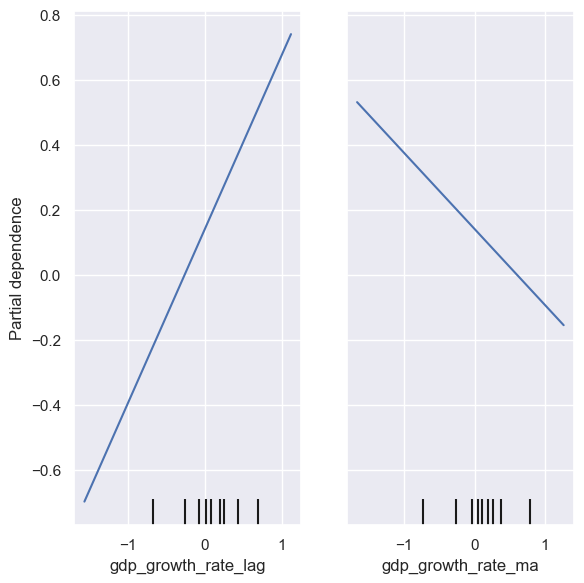

In [3568]:
X_transformed = best_model.named_steps['preprocessor'].transform(X_train)

plot = PartialDependenceDisplay.from_estimator(
    estimator,  
    X_transformed,                     
    features=X_train, # pyright: ignore[reportArgumentType]
    feature_names=X_train.columns
)

fig = plot.figure_
# plt.figure(figsize=(14, 8))
fig.set_size_inches(6, 6)
plt.tight_layout()
plt.show()

In [3569]:
y_pred = predictions[best_name]['y_test_pred']
residuals = y_test - y_pred

residuals_df = pd.DataFrame({'Residuals': residuals, 'Predicted': y_pred})

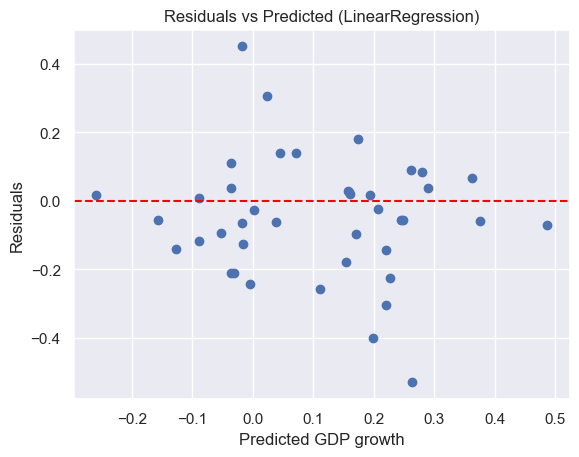

In [3570]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted GDP growth")
plt.ylabel("Residuals")
plt.title(f"Residuals vs Predicted ({best_name})")
plt.show()

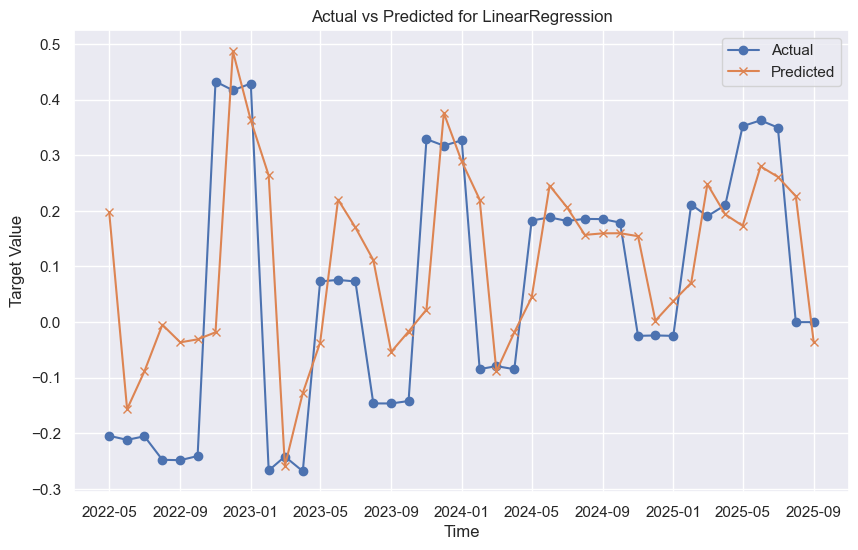

In [3571]:
y_test_indexed = y_test.copy()
y_test_indexed.index = y_test.index

plt.figure(figsize=(10,6))
plt.plot(y_test_indexed.index, y_test_indexed, label='Actual', marker='o')
plt.plot(y_test_indexed.index, y_pred, label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Target Value')
plt.title(f'Actual vs Predicted for {best_name}')
plt.legend()
plt.grid(True)
plt.show()

### Model 2 (Inflation Rate)

In [3572]:
target_col = 'inflation_rate'

In [3573]:
X_train = train.drop(columns=[target_col])
y_train = train[target_col]

X_test  = test.drop(columns=[target_col])
y_test  = test[target_col]

In [3574]:
discrete_features = X_train.dtypes == int

mi_scores = make_mi_scores(X_train, y_train, discrete_features) # pyright: ignore[reportArgumentType]
mi_scores[::].head(10)

inflation_rate_lag      1.004639
inflation_rate_ma       0.884233
inflation_rate_ewm      0.740934
education_attainment    0.738336
total_population        0.711050
gdp_per_capita          0.685946
gas_emissions           0.685281
price_index             0.644199
births                  0.624490
gdp                     0.571282
Name: MI Scores, dtype: float64

In [3575]:
drop_cols=[ 
    'deaths',
    'births',
    'net_migration',
    'household_income',
    'inflation_rate_ma', 
    'inflation_rate_ewm',
    'unemployment_rate_ma',
    'gdp',
    'gdp_growth_rate',
    'gdp_growth_rate_lag',
    'gdp_growth_rate_ma',
    'gdp_growth_rate_ewm',
    'gdp_per_capita',
    'education_attainment',
    'price_index',
    'energy_prices',
    # 'inflation_rate_m',
    'gas_emissions',
    'total_population',
    'net_population_growth',
    'growth_rate',
    'adult_unemployment_rate',
    'youth_unemployment_rate',
    # 'inflation_rate_lag',
    'unemployment_rate_lag',
    # 'unemployment_rate',
    'gdp_growth_rate_lag'
]

In [3576]:
X_train = X_train.drop(columns=[col for col in drop_cols if col in X_train.columns]) # pyright: ignore[reportAttributeAccessIssue]
X_test  = X_test.drop(columns=[col for col in drop_cols if col in X_test.columns])

numerical_cols = list(X_train.select_dtypes('number').columns)
categorical_cols = list(X_train.select_dtypes('object').columns)

print("Object Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Object Columns: []
Numerical Columns: ['inflation_rate_m', 'unemployment_rate', 'inflation_rate_lag']


In [3577]:
# Hyperparameter Tuning
for key, value in param_grids.items():
    parameter_tuning(key, models_tuning[key], 
                     value, numerical_cols, 
                     categorical_cols, X_train, y_train, 
                     refit='rmse')

Model - LinearRegression
{'model__fit_intercept': True, 'model__positive': True}
Model - RidgeRegression
{'model__alpha': 1.0, 'model__fit_intercept': True, 'model__solver': 'auto'}
Model - LassoRegression
{'model__alpha': 0.01, 'model__fit_intercept': True, 'model__max_iter': 5000, 'model__selection': 'random'}


In [3578]:
models = {
    "LinearRegression": LinearRegression(fit_intercept=True, positive=False),
    "RidgeRegression": Ridge(alpha=0.1, fit_intercept=True, solver='lsqr', random_state=RANDOM_STATE),
    "LassoRegression": Lasso(alpha=0.01, fit_intercept=True, max_iter=5000, selection='cyclic', random_state=RANDOM_STATE),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=50,
        max_depth=None,
        min_samples_leaf=4,
        min_samples_split=2,
        max_features='sqrt',
        random_state=RANDOM_STATE
    ),
    "XGBoost": XGBRegressor(
        n_estimators=100,
        colsample_bytree=1,
        gamma=0,
        reg_alpha=1,
        reg_lambda=5,
        max_depth=7,
        learning_rate=0.01,
        min_child_weight=1,
        subsample=1,
        random_state=RANDOM_STATE,
        tree_method="hist",
        verbosity=0
    )
    
}

Model - LinearRegression
{'model__fit_intercept': True, 'model__positive': True}

---

Model - RidgeRegression
{'model__alpha': 100.0, 'model__fit_intercept': True, 'model__solver': 'svd'}

---

Model - LassoRegression
{'model__alpha': 0.1, 'model__fit_intercept': True, 'model__max_iter': 5000, 'model__selection': 'cyclic'}

---

Model - RandomForestRegressor
{'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50}

In [3579]:
metrics_df, best_name, best_model, predictions, models_trained = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    numerical_cols, categorical_cols, models
)


--- Training LinearRegression ---

--- Training RidgeRegression ---

--- Training LassoRegression ---

--- Training RandomForestRegressor ---

--- Training XGBoost ---


In [3580]:
metrics_df.head()

,Model,Train R²,Test R²,Train MAE,Test MAE,Train RMSE,Test RMSE
0,LinearRegression,0.879046,0.951968,0.239128,0.540145,0.305447,0.690716
1,RidgeRegression,0.879046,0.951889,0.239128,0.541002,0.305447,0.691281
2,LassoRegression,0.878738,0.949921,0.240019,0.555168,0.305837,0.705284
3,RandomForestRegressor,0.860674,-0.575520,0.242078,2.687858,0.327826,3.955909
4,XGBoost,0.682779,-0.566019,0.363600,2.720634,0.494661,3.943963


In [3581]:
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
ols_model = sm.OLS(y_train, X_train_transformed).fit()
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:         inflation_rate   R-squared (uncentered):                   0.230
Model:                            OLS   Adj. R-squared (uncentered):              0.217
Method:                 Least Squares   F-statistic:                              17.40
Date:                Wed, 05 Nov 2025   Prob (F-statistic):                    6.22e-10
Time:                        20:00:22   Log-Likelihood:                         -325.65
No. Observations:                 178   AIC:                                      657.3
Df Residuals:                     175   BIC:                                      666.8
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [3582]:
estimator = best_model.named_steps['model']
all_feature = list(numerical_cols)
importance_df = get_feature_importance(estimator, all_feature)

print(importance_df.head(10))

              Feature  Importance
2  inflation_rate_lag    0.802387
0    inflation_rate_m    0.131752
1   unemployment_rate    0.012625


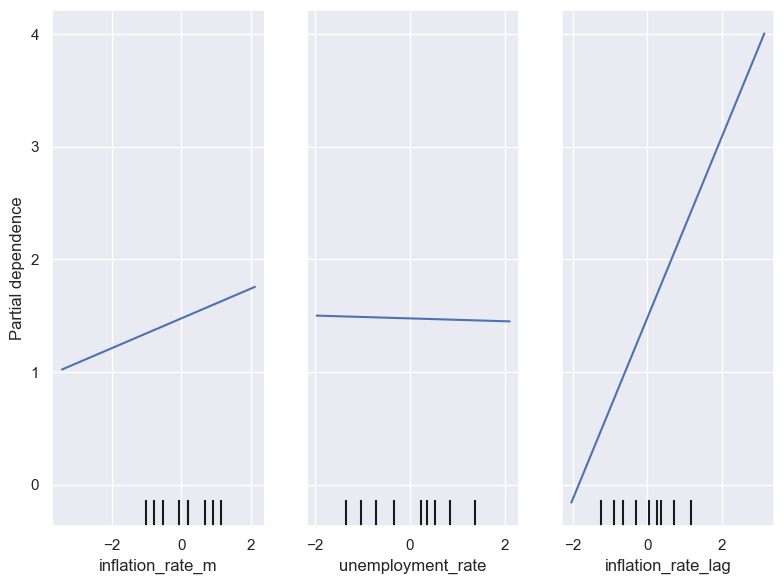

In [3583]:
X_transformed = best_model.named_steps['preprocessor'].transform(X_train)

plot = PartialDependenceDisplay.from_estimator(
    estimator,  
    X_transformed,                     
    features=X_train, # pyright: ignore[reportArgumentType]
    feature_names=X_train.columns
)

fig = plot.figure_
fig.set_size_inches(8, 6)
plt.tight_layout()
plt.show()

In [3584]:
y_pred = predictions[best_name]['y_test_pred']
residuals = y_test - y_pred

residuals_df = pd.DataFrame({'Residuals': residuals, 'Predicted': y_pred})

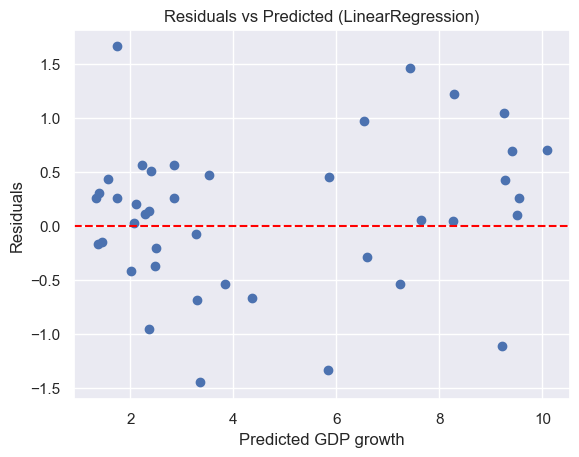

In [3585]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted GDP growth")
plt.ylabel("Residuals")
plt.title(f"Residuals vs Predicted ({best_name})")
plt.show()

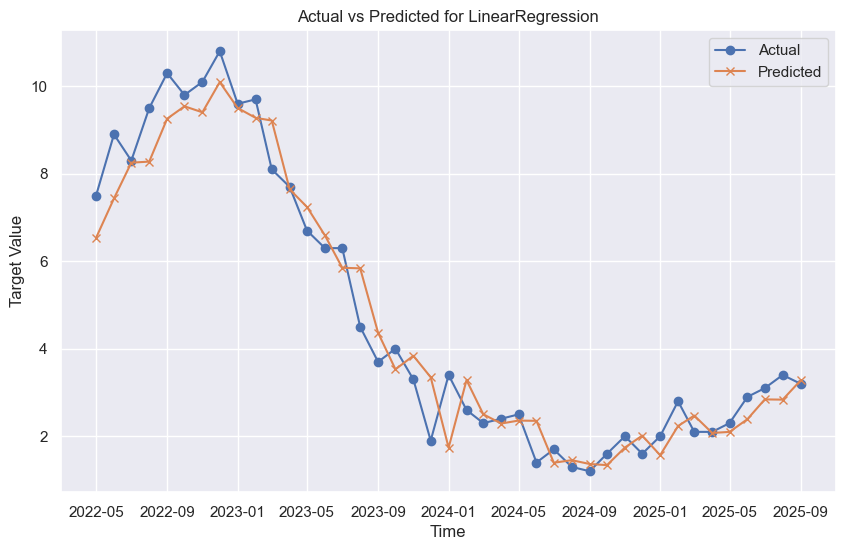

In [3586]:
y_test_indexed = y_test.copy()
y_test_indexed.index = y_test.index

plt.figure(figsize=(10,6))
plt.plot(y_test_indexed.index, y_test_indexed, label='Actual', marker='o')
plt.plot(y_test_indexed.index, y_pred, label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Target Value')
plt.title(f'Actual vs Predicted for {best_name}')
plt.legend()
plt.grid(True)
plt.show()

### Model 3 (Unemployment Rate)

In [3587]:
target_col = 'unemployment_rate'

In [3588]:
X_train = train.drop(columns=[target_col])
y_train = train[target_col]

X_test  = test.drop(columns=[target_col])
y_test  = test[target_col]

In [3589]:
discrete_features = X_train.dtypes == int

mi_scores = make_mi_scores(X_train, y_train, discrete_features) # pyright: ignore[reportArgumentType]
mi_scores[::].head(10)

adult_unemployment_rate    1.207842
unemployment_rate_ma       1.131624
education_attainment       1.097030
total_population           1.050614
unemployment_rate_lag      1.009749
price_index                1.000753
youth_unemployment_rate    0.933357
gas_emissions              0.912924
gdp                        0.771586
gdp_per_capita             0.762297
Name: MI Scores, dtype: float64

In [3590]:
drop_cols=[ 
    'deaths',
    'births',
    'net_migration',
    'household_income',
    'inflation_rate_ma', 
    'inflation_rate_ewm',
    # 'unemployment_rate_ma',
    'gdp',
    # 'gdp_growth_rate',
    'gdp_growth_rate_lag',
    'gdp_growth_rate_ma',
    'gdp_growth_rate_ewm',
    # 'gdp_per_capita',
    'education_attainment',
    'price_index',
    'energy_prices',
    'inflation_rate_m',
    'gas_emissions',
    'total_population',
    'net_population_growth',
    'growth_rate',
    'adult_unemployment_rate',
    'youth_unemployment_rate',
    'inflation_rate_lag',
    # 'unemployment_rate_lag',
    'gdp_growth_rate_lag',
    # 'inflation_rate',
]

In [3591]:
X_train = X_train.drop(columns=[col for col in drop_cols if col in X_train.columns]) # pyright: ignore[reportAttributeAccessIssue]
X_test  = X_test.drop(columns=[col for col in drop_cols if col in X_test.columns])

numerical_cols = list(X_train.select_dtypes('number').columns)
categorical_cols = list(X_train.select_dtypes('object').columns)

print("Object Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Object Columns: []
Numerical Columns: ['gdp_per_capita', 'inflation_rate', 'gdp_growth_rate', 'unemployment_rate_lag', 'unemployment_rate_ma']


In [3592]:
# Hyperparameter Tuning
for key, value in param_grids.items():
    parameter_tuning(key, models_tuning[key], 
                     value, numerical_cols, 
                     categorical_cols, X_train, y_train, 
                     refit='rmse')

Model - LinearRegression
{'model__fit_intercept': True, 'model__positive': True}
Model - RidgeRegression
{'model__alpha': 10.0, 'model__fit_intercept': True, 'model__solver': 'lsqr'}
Model - LassoRegression
{'model__alpha': 0.1, 'model__fit_intercept': True, 'model__max_iter': 5000, 'model__selection': 'random'}


In [ ]:
models = {
    "LinearRegression": LinearRegression(fit_intercept=True, positive=False),
    "RidgeRegression": Ridge(alpha=10.0, fit_intercept=True, solver='lsqr', random_state=RANDOM_STATE),
    "LassoRegression": Lasso(alpha=0.1, fit_intercept=True, max_iter=5000, selection='random', random_state=RANDOM_STATE),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=50,
        max_depth=None,
        min_samples_leaf=4,
        min_samples_split=2,
        max_features='sqrt',
        random_state=RANDOM_STATE
    ),
    "XGBoost": XGBRegressor(
        n_estimators=100,
        colsample_bytree=1,
        gamma=0,
        reg_alpha=1,
        reg_lambda=5,
        max_depth=7,
        learning_rate=0.01,
        min_child_weight=1,
        subsample=1,
        random_state=RANDOM_STATE,
        tree_method="hist",
        verbosity=0
    )
    
}

Model - LinearRegression
{'model__fit_intercept': True, 'model__positive': True}

---

Model - RidgeRegression
{'model__alpha': 100.0, 'model__fit_intercept': True, 'model__solver': 'svd'}

---

Model - LassoRegression
{'model__alpha': 0.1, 'model__fit_intercept': True, 'model__max_iter': 5000, 'model__selection': 'cyclic'}

---

Model - RandomForestRegressor
{'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50}

In [3594]:
metrics_df, best_name, best_model, predictions, models_trained = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    numerical_cols, categorical_cols, models
)


--- Training LinearRegression ---

--- Training RidgeRegression ---

--- Training LassoRegression ---

--- Training RandomForestRegressor ---

--- Training XGBoost ---


In [3595]:
metrics_df.head()

,Model,Train R²,Test R²,Train MAE,Test MAE,Train RMSE,Test RMSE
0,LinearRegression,0.886129,0.535138,0.239476,0.313248,0.324104,0.432257
1,RidgeRegression,0.886128,0.534567,0.239472,0.313199,0.324105,0.432522
2,LassoRegression,0.885749,0.557451,0.239865,0.315406,0.324643,0.421756
3,RandomForestRegressor,0.929517,0.514908,0.184000,0.349828,0.254988,0.441563
4,XGBoost,0.740751,0.273883,0.391663,0.440492,0.489030,0.540236


In [3596]:
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
ols_model = sm.OLS(y_train, X_train_transformed).fit()
print(ols_model.summary())

                                 OLS Regression Results                                
Dep. Variable:      unemployment_rate   R-squared (uncentered):                   0.014
Model:                            OLS   Adj. R-squared (uncentered):             -0.015
Method:                 Least Squares   F-statistic:                             0.4904
Date:                Wed, 05 Nov 2025   Prob (F-statistic):                       0.783
Time:                        20:00:25   Log-Likelihood:                         -613.44
No. Observations:                 178   AIC:                                      1237.
Df Residuals:                     173   BIC:                                      1253.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [3597]:
estimator = best_model.named_steps['model']
all_feature = list(numerical_cols)
importance_df = get_feature_importance(estimator, all_feature)

print(importance_df.head(10))

                 Feature  Importance
4   unemployment_rate_ma    0.650222
3  unemployment_rate_lag    0.245192
0         gdp_per_capita    0.025053
2        gdp_growth_rate    0.014699
1         inflation_rate    0.000000


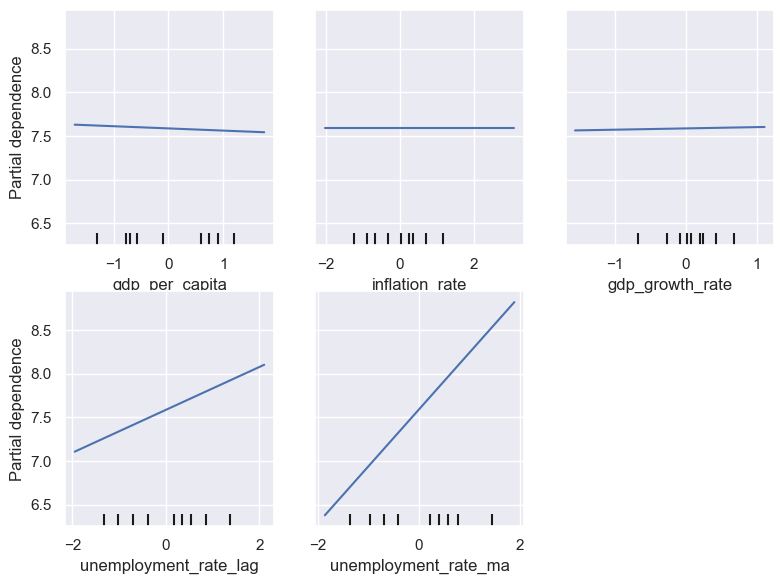

In [3598]:
X_transformed = best_model.named_steps['preprocessor'].transform(X_train)

plot = PartialDependenceDisplay.from_estimator(
    estimator,  
    X_transformed,                     
    features=X_train, # pyright: ignore[reportArgumentType]
    feature_names=X_train.columns
)

fig = plot.figure_
fig.set_size_inches(8, 6)
plt.tight_layout()
plt.show()

In [3599]:
y_pred = predictions[best_name]['y_test_pred']
residuals = y_test - y_pred

residuals_df = pd.DataFrame({'Residuals': residuals, 'Predicted': y_pred})

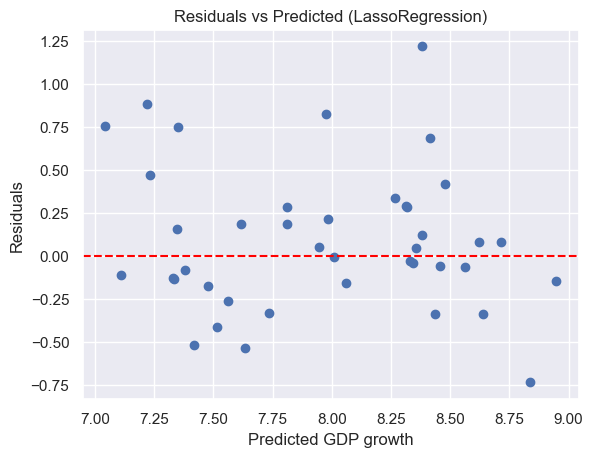

In [3600]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted GDP growth")
plt.ylabel("Residuals")
plt.title(f"Residuals vs Predicted ({best_name})")
plt.show()

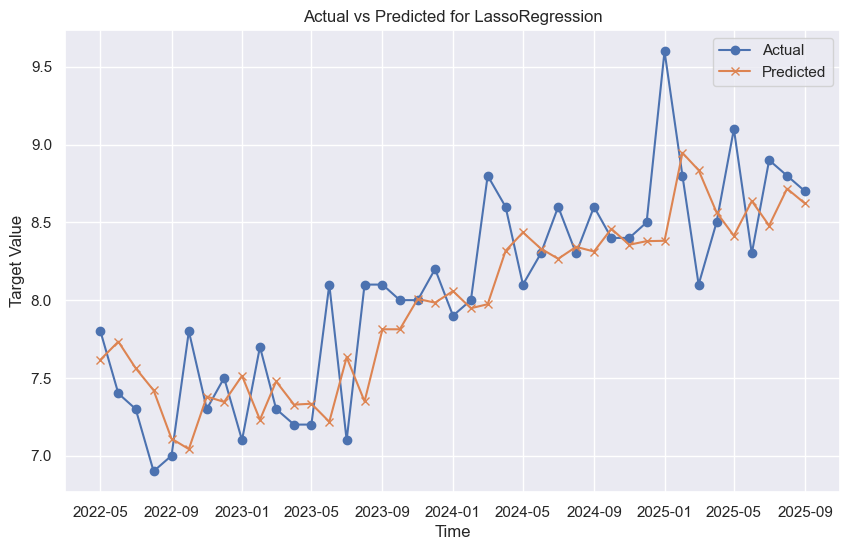

In [3601]:
y_test_indexed = y_test.copy()
y_test_indexed.index = y_test.index

plt.figure(figsize=(10,6))
plt.plot(y_test_indexed.index, y_test_indexed, label='Actual', marker='o')
plt.plot(y_test_indexed.index, y_pred, label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Target Value')
plt.title(f'Actual vs Predicted for {best_name}')
plt.legend()
plt.grid(True)
plt.show()